In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("./index_data.csv")
data['date'] = pd.to_datetime(data['date'])

#### **动量因子风格择时信号：**

##### 需要数据： 沪深300指数和中证1000指数日收盘价 
##### 信号逻辑： 取前第一日和第十一日指数收盘价计算过去十天指数收益率：
#####        (1) 沪深300指数收益率 > 中证1000指数收益率： 当天开盘买入沪深300指数,收盘平仓
#####        (2) 沪深300指数收益率 < 中证1000指数收益率： 当天开盘买入中证1000指数，收盘平仓
#####        (3) 若两者收益率均小于0：当天空仓

In [4]:
data["CSI300_Close_1"] = data['CSI300_Close'].shift()
data["CSI300_Close_11"] = data['CSI300_Close'].shift(11)
data["CSI1000_Close_1"] = data['CSI1000_Close'].shift()
data["CSI1000_Close_11"] = data['CSI1000_Close'].shift(11)
data['10_days_CSI300_rtn'] = data['CSI300_Close_1']/data['CSI300_Close_11']-1
data['10_days_CSI1000_rtn'] = data['CSI1000_Close_1']/data['CSI1000_Close_11']-1
data['Signal1'] = np.where(data['10_days_CSI300_rtn'] > data['10_days_CSI1000_rtn'], 1, -1)
data.loc[(data['10_days_CSI300_rtn'] * data['10_days_CSI1000_rtn'] > 0) & (data['10_days_CSI300_rtn'] < 0), 'Signal1'] = 0
data['Signal1_day_rtn'] = np.where(data['10_days_CSI300_rtn'] > data['10_days_CSI1000_rtn'], data['CSI300_Close']/data['CSI300_Close_1'], data['CSI1000_Close']/data['CSI1000_Close_1'])
data.loc[(data['10_days_CSI300_rtn'] * data['10_days_CSI1000_rtn'] > 0) & (data['10_days_CSI300_rtn'] < 0), 'Signal1_day_rtn'] = 1
data['Signal1_rtn'] = np.cumprod(data['Signal1_day_rtn'])

<Axes: xlabel='date', ylabel='Signal1_rtn'>

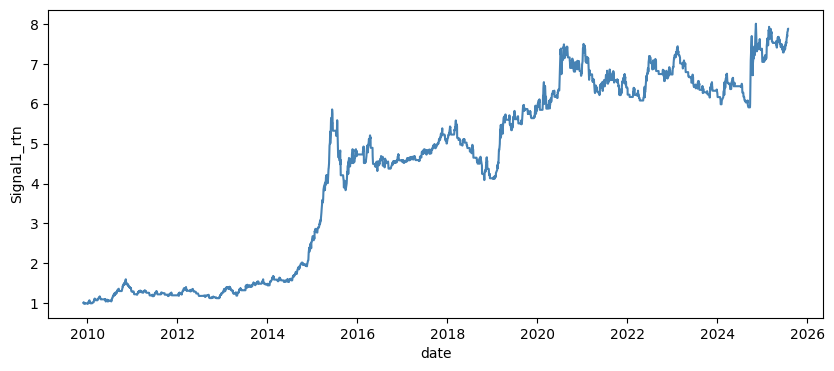

In [5]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='date',y='Signal1_rtn',data=data,color='steelblue')

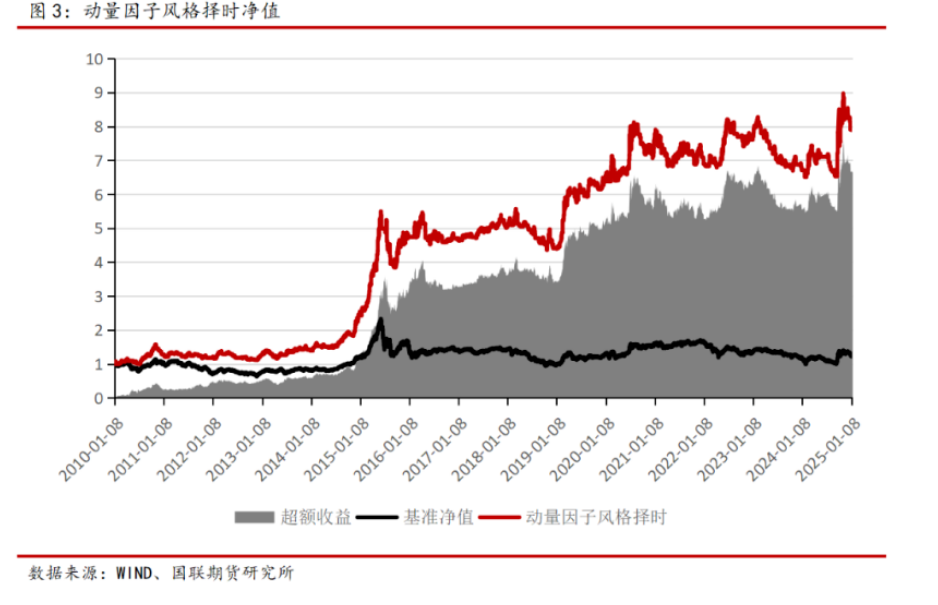

#### **拥挤度动量因子风格择时信号：**

##### 需要数据： 大盘价值指数PB,小盘成长指数PB，万得全A指数PB 
##### 信号逻辑： 取前第一日和第五日指数PB计算指标：
#####           R1 = (大盘价值指数PB-小盘成长指数PB)/万得全A指数PB
#####        (1) R1(t-1) > R1(t-5)： 当天开盘买入沪深300指数,收盘平仓
#####        (2) R1(t-1) < R1(t-5)： 当天开盘买入中证1000指数，收盘平仓

In [6]:
data['LCVI_PB_1'] = data['LCVI_PB'].shift()
data['LCVI_PB_5'] = data['LCVI_PB'].shift(5)
data['SCGI_PB_1'] = data['SCGI_PB'].shift()
data['SCGI_PB_5'] = data['SCGI_PB'].shift(5)
data['WASI_PB_1'] = data['WASI_PB'].shift()
data['WASI_PB_5'] = data['WASI_PB'].shift(5)

In [7]:
data['Signal2'] = np.where((data['LCVI_PB_1'] - data['SCGI_PB_1'])/data['WASI_PB_1'] > (data['LCVI_PB_5'] - data['SCGI_PB_5'])/data['WASI_PB_5'], 1, -1)
data['Signal2_day_rtn'] = np.where((data['LCVI_PB_1'] - data['SCGI_PB_1'])/data['WASI_PB_1'] > (data['LCVI_PB_5'] - data['SCGI_PB_5'])/data['WASI_PB_5'], data['CSI300_Close']/data['CSI300_Close_1'], data['CSI1000_Close']/data['CSI1000_Close_1'])
data['Signal2_rtn'] = np.cumprod(data['Signal2_day_rtn'])

<Axes: xlabel='date', ylabel='Signal2_rtn'>

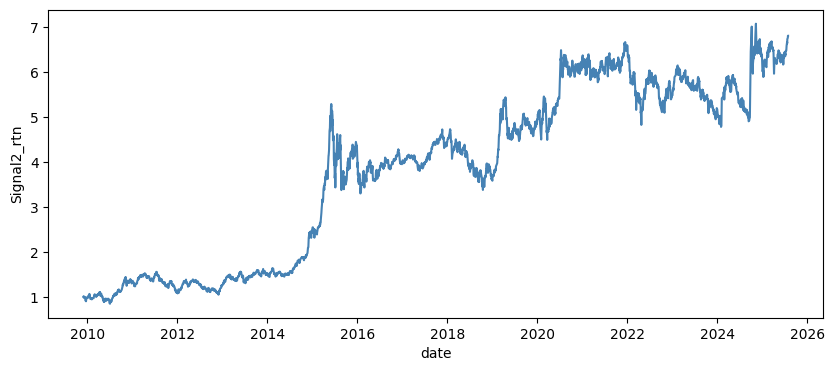

In [8]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='date',y='Signal2_rtn',data=data,color='steelblue')

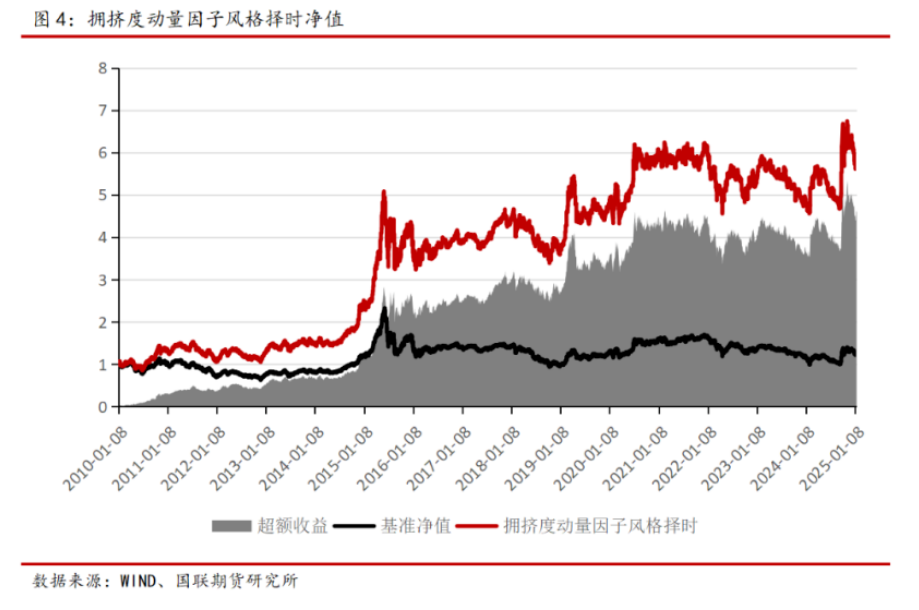

#### **相对强弱动量因子风格择时信号（大盘价值指数和小盘成长指数）**

##### 需要数据： 大盘价值指数、小盘成长指数、万得全A指数收盘价 
##### 信号逻辑： 取前第一日和第二日指数收盘价计算指标：
#####           d1 = 大盘价值指数日收益率(t-1)-万得全A指数日收益率(t-1)
#####           d2 = 小盘成长指数日收益率(t-1)-万得全A指数日收益率(t-1)
#####        (1) d1，d2小于0.2%： 空仓
#####        (2) d1 > d2: 择时沪深300指数
#####        (3) d1 < d2: 择时中证1000指数

In [9]:
data['LCVI_Close_1'] = data['LCVI_Close'].shift()
data['LCVI_Close_2'] = data['LCVI_Close'].shift(2)
data['SCGI_Close_1'] = data['SCGI_Close'].shift()
data['SCGI_Close_2'] = data['SCGI_Close'].shift(2)
data['WASI_Close_1'] = data['WASI_Close'].shift()
data['WASI_Close_2'] = data['WASI_Close'].shift(2)

In [10]:
LCVI_rtn_1 = data['LCVI_Close_1']/data['LCVI_Close_2']
SCGI_rtn_1 = data['SCGI_Close_1']/data['SCGI_Close_2']
WASI_rtn_1 = data['WASI_Close_1']/data['WASI_Close_2']

data['Signal3'] = np.where(LCVI_rtn_1 > SCGI_rtn_1, 1, -1)
data.loc[(LCVI_rtn_1 - WASI_rtn_1 < 0.002) & (SCGI_rtn_1 - WASI_rtn_1 < 0.002),'Signal3'] = 0
data['Signal3_day_rtn'] = np.where(LCVI_rtn_1 > SCGI_rtn_1, data['CSI300_Close']/data['CSI300_Close_1'], data['CSI1000_Close']/data['CSI1000_Close_1'])
data.loc[(LCVI_rtn_1 - WASI_rtn_1 < 0.002) & (SCGI_rtn_1 - WASI_rtn_1 < 0.002),'Signal3_day_rtn'] = 1
data['Signal3_rtn'] = np.cumprod(data['Signal3_day_rtn'])

<Axes: xlabel='date', ylabel='Signal3_rtn'>

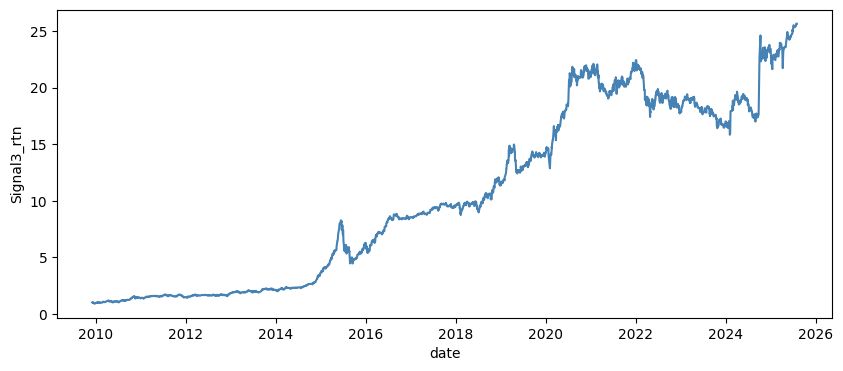

In [11]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='date',y='Signal3_rtn',data=data,color='steelblue')

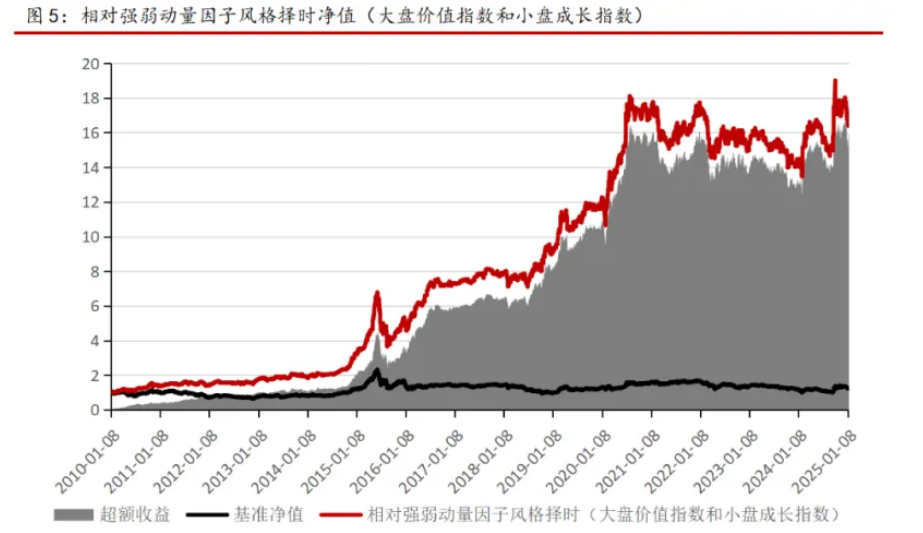

#### **相对强弱动量因子风格择时信号（沪深300指数和中证1000指数）**

##### 需要数据： 沪深300指数、中证1000指数、万得全A指数收盘价 
##### 信号逻辑： 取前第一日和第二日指数收盘价计算指标：
#####           d1 = 沪深300指数日收益率(t-1)-万得全A指数日收益率(t-1)
#####           d2 = 中证1000指数日收益率(t-1)-万得全A指数日收益率(t-1)
#####        (1) d1，d2小于0.2%： 空仓
#####        (2) d1 > d2: 择时沪深300指数
#####        (3) d1 < d2: 择时中证1000指数

In [12]:
data['CSI300_Close_2'] = data['CSI300_Close'].shift(2)
data['CSI1000_Close_2'] = data['CSI1000_Close'].shift(2)

In [13]:
CSI300_rtn_1 = data['CSI300_Close_1']/data['CSI300_Close_2']
CSI1000_rtn_1 = data['CSI1000_Close_1']/data['CSI1000_Close_2']

data['Signal4'] = np.where(CSI300_rtn_1 > CSI1000_rtn_1, 1, -1)
data.loc[(CSI300_rtn_1 - WASI_rtn_1 < 0.002) & (CSI1000_rtn_1 - WASI_rtn_1 < 0.002),'Signal4'] = 0
data['Signal4_day_rtn'] = np.where(CSI300_rtn_1 > CSI1000_rtn_1, data['CSI300_Close']/data['CSI300_Close_1'], data['CSI1000_Close']/data['CSI1000_Close_1'])
data.loc[(CSI300_rtn_1 - WASI_rtn_1 < 0.002) & (CSI1000_rtn_1 - WASI_rtn_1 < 0.002),'Signal4_day_rtn'] = 1
data['Signal4_rtn'] = np.cumprod(data['Signal4_day_rtn'])

<Axes: xlabel='date', ylabel='Signal4_rtn'>

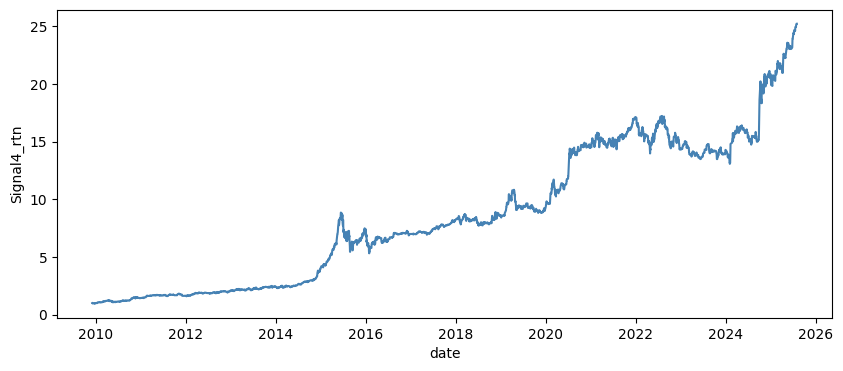

In [14]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='date',y='Signal4_rtn',data=data,color='steelblue')

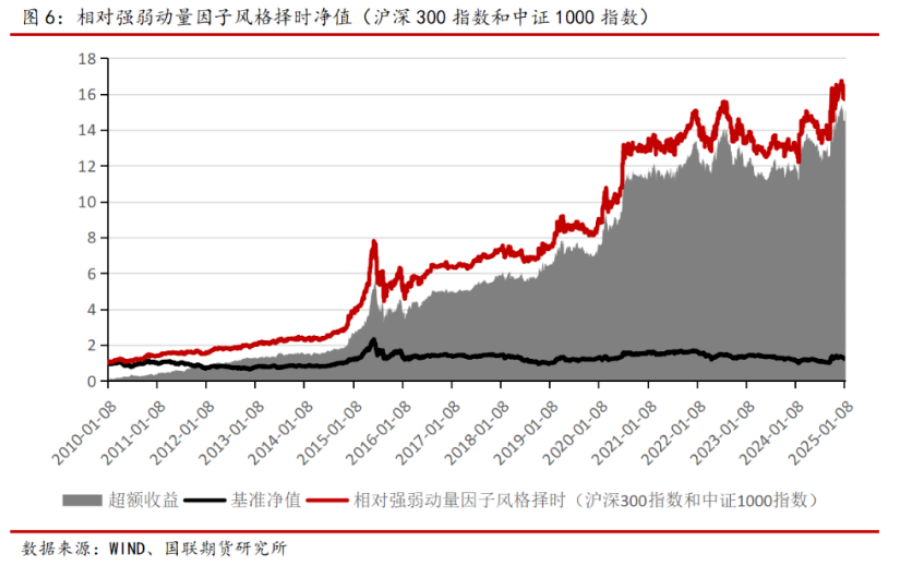

#### **多维动量复合风格择时对冲信号**

##### 信号逻辑： 根据以上四个信号计算指标
#####          c1 = 择时沪深300指数信号数量
#####          c2 = 择时中证1000指数信号数量
#####         (1) c1 - c2 > 2: 7.5%多IF + 7.5%空IM
#####         (2) 0 < c1 - c2 < 2: 5%多IF + 5%空IM
#####         (3) c1 - c2 = 0: 空仓
#####         (4) -2 < c1 - c2 < 0: 5%多IM + 5%空IF
#####         (5) c1 - c2 < -2: 7.5%多IM + 7.5%空IF

In [15]:
margin = 0.12
data['Signal_all'] = data['Signal1'] + data['Signal2'] + data['Signal3'] + data['Signal4']
condlist = [data['Signal_all'] > 2, data['Signal_all'] > 0, data['Signal_all'] == 0, data['Signal_all'] > -2]
choicelist = [(data['CSI300_Close']/data['CSI300_Close_1']-1)*0.075/margin-(data['CSI1000_Close']/data['CSI1000_Close_1']-1)*0.075/margin+1, (data['CSI300_Close']/data['CSI300_Close_1']-1)*0.05/margin-(data['CSI1000_Close']/data['CSI1000_Close_1']-1)*0.05/margin+1, 1, -(data['CSI300_Close']/data['CSI300_Close_1']-1)*0.05/margin+(data['CSI1000_Close']/data['CSI1000_Close_1']-1)*0.05/margin+1]
data['Signal_all_day_rtn'] = np.select(condlist, choicelist,default = -(data['CSI300_Close']/data['CSI300_Close_1']-1)*0.075/margin+(data['CSI1000_Close']/data['CSI1000_Close_1']-1)*0.075/margin+1)
data['Signal_all_rtn'] = np.cumprod(data['Signal_all_day_rtn'])

<Axes: xlabel='date', ylabel='Signal_all_rtn'>

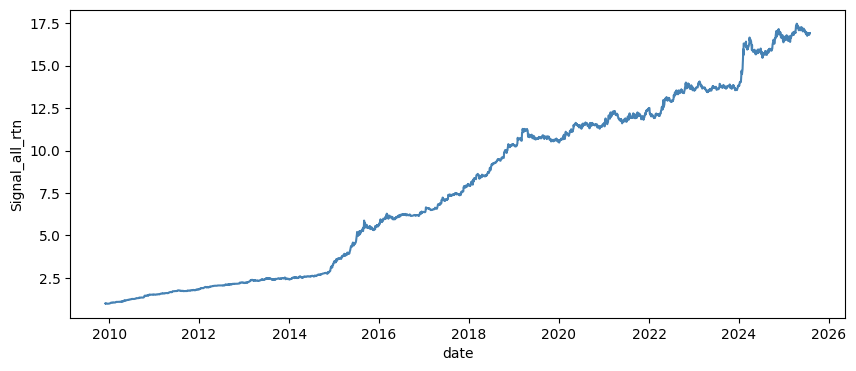

In [16]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='date',y='Signal_all_rtn',data=data,color='steelblue')